In [19]:
import numpy as np
from matplotlib import pyplot as plt
import time
%matplotlib inline

# 10-armed bandit

The bandit:
- Mean and variance for each arm. The means represent $Q^*(a)$
- Ability to interact with the bandit - specifically simulate a play on one of its arms
- Bandit represented as a 2D array - rows are arms, columns are (mean, variance)
- Bandit array built by generating 10 means (from a guassian, mean 0 and variance 1), variances are 1

The agent:
- Maintains:
  - list of estimates of $Q_t(a)$ (Estimated value of each action $a$)
  - Current "play" number $k$
- Determines action to take, given $Q_t(a)$ and $k$

Running plays:
- Ask agent for an agent
- Get response from bandit for action
- Give response to agent

In [52]:
class Bandit(object):
    def __init__(self, mean_variances):
        self.mean_variances = mean_variances
    
    def get_response(self, arm_index):
        mean, variance = self.mean_variances[arm_index]
        return np.random.normal(mean, variance)
    
    def optimal_action(self):
        return np.argmax([mean_var[0] for mean_var in self.mean_variances])

def make_bandit(n_bandits, mean_reward_mean=0, var_reward_mean=1, mean_reward_var=1, var_reward_var=0):
    mean_vars =  [(np.random.normal(mean_reward_mean, var_reward_mean),
                   np.random.normal(mean_reward_var, var_reward_var)) for _ in range(n_bandits)]
    return Bandit(mean_vars)

In [59]:
class Agent(object):
    def __init__(self, estimated_action_values, explore_chance=0):
        self.estimated_action_values = estimated_action_values
        self.explore_chance = explore_chance
        self.rewards = []
    
    def get_action(self):
        best = self.preferred_action()
        if self.should_explore():
            return self.exploratory_action(not_=best)
        else:
            return best
        
    def preferred_action(self):
        return np.argmax(self.estimated_action_values)
    
    def should_explore(self):
        return np.random.random() < self.explore_chance
    
    def exploratory_action(self, not_=-1):
        rand_action = np.random.randint(0, len(self.estimated_action_values))
        if rand_action == not_:
            return self.exploratory_action(not_)
        else:
            return rand_action
    
    def update(self, action, reward, play_number):
        self.rewards.append(reward)
        action_value = self.estimated_action_values[action]
        new_action_value = action_value + (1 / play_number) * (reward - action_value)
        self.estimated_action_values[action] = new_action_value
        
    def mean_reward(self):
        return np.mean(self.rewards)
    
def make_agent(bandit_num_arms, initial_estimated_action_value, explore_chance) -> Agent:
    return Agent([initial_estimated_action_value for _ in range(bandit_num_arms)], explore_chance)

In [82]:
def iter_plays(bandit, agent, num_plays=1000, print_=False):
    for play_number in range(1, num_plays+1):
        action = agent.get_action()
        print_ and print(f"Agent action values {agent.estimated_action_values}")
        print_ and print(f"Agent chose {action}")
        response = bandit.get_response(action)
        print_ and print(f"Reward: {response}")
        print_ and print("\n##################\n")
        agent.update(action, response, play_number)
        print_ and time.sleep(1)
        yield bandit, agent

In [88]:
bandit, agent = make_bandit(10), make_agent(10, 0, 0.1)

all_on_optimal_actions = []
all_mean_rewards = []
for _repeat in range(50):
    print(_repeat, end=', ')
    on_optimal_action = []
    mean_rewards = []
    for bandit, agent in iter_plays(bandit, agent):
        on_optimal_action.append(int(bandit.optimal_action() == agent.preferred_action()))
        mean_rewards.append(agent.mean_reward())
    all_on_optimal_actions.append(on_optimal_action)
    all_mean_rewards.append(mean_rewards)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [89]:
all_mean_rewards = np.array(all_mean_rewards)
all_on_optimal_actions = np.array(all_on_optimal_actions)

In [90]:
all_mean_rewards_avg = all_mean_rewards.mean(axis=0)
perc_optimal_actions = 100 * all_on_optimal_actions.mean(axis=0)

In [96]:
all_mean_rewards[:5,:10]

array([[ 2.86007848,  2.05631043,  1.34062452,  1.11248447,  1.15959377,
         1.30855559,  1.41557077,  1.14528938,  1.16494117,  0.99939351],
       [ 1.00016908,  0.99872877,  0.99916657,  0.99886093,  0.9987858 ,
         0.99894035,  1.00089269,  1.00166971,  1.00230388,  1.00408284],
       [ 1.04026022,  1.03968227,  1.03986265,  1.04026201,  1.04062931,
         1.04030139,  1.0406275 ,  1.04199841,  1.04152889,  1.04224188],
       [ 1.05952844,  1.05988429,  1.06010341,  1.05958311,  1.06013388,
         1.06103757,  1.06094619,  1.06132569,  1.06151515,  1.06072303],
       [ 1.06452114,  1.06442213,  1.06408711,  1.06404381,  1.06413679,
         1.06432902,  1.06387829,  1.06414931,  1.06452403,  1.06381407]])

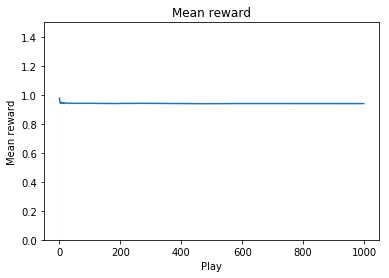

In [94]:
plt.figure()
plt.title("Mean reward")
plt.plot(all_mean_rewards_avg)
plt.fill_between(all_mean_rewards_avg - all_mean_rewards_avg.std(axis=0),
                 all_mean_rewards_avg + all_mean_rewards_avg.std(axis=0))
plt.xlabel("Play")
plt.ylabel("Mean reward")
plt.ylim(0,1.5)
plt.show()

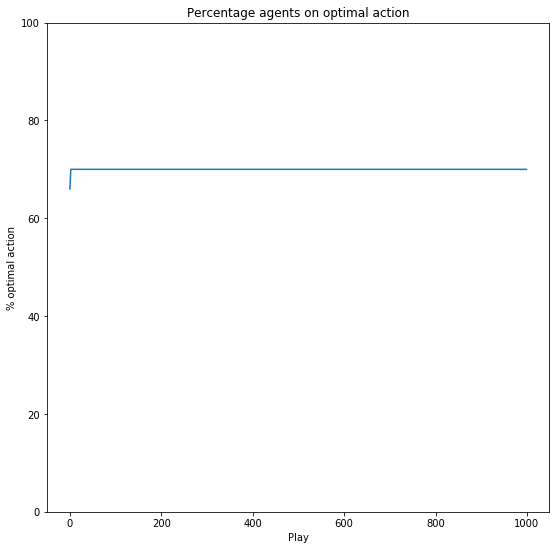

In [93]:
plt.figure(figsize=(9,9))
plt.title("Percentage agents on optimal action")
plt.plot(perc_optimal_actions)
plt.xlabel("Play")
plt.ylabel("% optimal action")
plt.ylim(0,100)
plt.show()